# CRISPRGenie

This is the main notebook for the project *CRISPRGenie*. The current aim of the project is as follows:
1. The input dataset contains **sgRNA** sequences for a total of 19k different genes from the human genome. 
2. The model will be trained on all the sequences to predict different possible sgRNA sequences based on the input target gene.
3. The model will be autoregressive, i.e., it will predict new sequences based on its training data. Furthermore, the model will ideally contain a semi-supervised regression task which will allow the model to predict the metrics of the newly predicted sgRNA sequence/s for the given target.
4. The metrics include the log2-fold changes and the effect (ranging from -9 to 9)

The model training will take place in two steps:

#### Part 1: Generating sgRNA Sequences

**Model Design:**

* Input: Gene symbol (e.g., ENSG00000148584)
* Output: Set of sgRNA sequences

**Approach:**

* Data Preparation: For training, map each gene symbol to its corresponding sgRNA sequences. This could involve aggregating all sgRNA sequences that target a specific gene into a single training example.
* Model Type: Use a generative model like GPT, which is adept at producing sequences. Train the model to generate sgRNA sequences when provided with a gene symbol.

**Training:**

* Input: Gene symbol.
* Output: A sequence of sgRNAs or a concatenated string of multiple sgRNAs.
Train the model to maximize the likelihood of generating correct sgRNA sequences given a gene symbol.

#### Part 2: Predicting Effect Metrics

**Model Design:**

* Input: sgRNA sequence
* Output: Effect metrics (quantized effect as an integer from -9 to 9)

**Approach:**

* Data Preparation: Use sgRNA sequences and their corresponding effect metrics from your dataset.
* Model Type: A classification model (like BERT used for classification tasks) that can predict a class (effect metric) for each sgRNA sequence.

**Training:**

* Input: sgRNA sequence.
* Output: Effect class.
This model can be trained using a cross-entropy loss where each class corresponds to a different quantile of sgRNA efficacy.

# Part-1 Generating sgRNA Sequences

## Data Preparation

In [30]:
# Importing the necessary libraries
import pandas as pd
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import numpy as np
from transformers import GPT2Config, GPT2LMHeadModel
from torch.optim import AdamW
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('../data/GenomeCRISPR.csv')
df.head()

/var/folders/bd/pmctg31s2cd83x3j_64l4fzc0000gn/T/ipykernel_12889/990911958.py:1: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/GenomeCRISPR.csv')


,start,end,chr,strand,pubmed,cellline,condition,sequence,symbol,ensg,log2fc,rc_initial,rc_final,effect,cas,screentype
0,50844073,50844096,10,+,26472758,Jiyoye,viability,GCAGCATCCCAACCAGGTGGAGG,A1CF,ENSG00000148584,0.315907,{260},{244},2,hSpCas9,negative selection
1,50814011,50814034,10,-,26472758,Jiyoye,viability,GCGGGAGTGAGAGGACTGGGCGG,A1CF,ENSG00000148584,2.144141,{17},{59},9,hSpCas9,negative selection
2,50836111,50836134,10,+,26472758,Jiyoye,viability,ATGACTCTCATACTCCACGAAGG,A1CF,ENSG00000148584,1.426034,{75},{153},8,hSpCas9,negative selection
3,50836095,50836118,10,-,26472758,Jiyoye,viability,GAGTCATCGAGCAGCTGCCATGG,A1CF,ENSG00000148584,1.550133,{47},{105},8,hSpCas9,negative selection
4,50816234,50816257,10,-,26472758,Jiyoye,viability,AGTCACCCTAGCAAAACCAGTGG,A1CF,ENSG00000148584,0.382513,{58},{57},3,hSpCas9,negative selection


In [4]:
# Extract only the necessary columns
data_relevant = df[['ensg', 'sequence']]

# Drop any rows with missing values in these columns to ensure data integrity
data_relevant = data_relevant.dropna()

# take the first 1k instances as a test
data_relevant = data_relevant[:1000]

data_relevant.head()


,ensg,sequence
0,ENSG00000148584,GCAGCATCCCAACCAGGTGGAGG
1,ENSG00000148584,GCGGGAGTGAGAGGACTGGGCGG
2,ENSG00000148584,ATGACTCTCATACTCCACGAAGG
3,ENSG00000148584,GAGTCATCGAGCAGCTGCCATGG
4,ENSG00000148584,AGTCACCCTAGCAAAACCAGTGG


In [31]:
# Split the data into train, val and test sets
train_df, temp_df = train_test_split(data_relevant, test_size=0.7, random_state=42)  # 70% train, 40% temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # Split temp into 15% val, 15% test

### Tokenization 

Since the current dataset has a much smaller vocabulary, I will be going with a custom tokenizer which will be lightweight compared to the pretrained tokenizer of GPT2

In [32]:
class CustomTokenizer:
    def __init__(self):
        # Include all nucleotide bases, special tokens, and necessary characters for gene IDs
        self.token_to_id = {
            '[PAD]': 0, '[ID]': 1, '[SOS]': 2, '[EOS]': 3,
            'A': 4, 'T': 5, 'G': 6, 'C': 7, 
            'E': 8, 'N': 9, 'S': 10, 
            '0': 11, '1': 12, '2': 13, '3': 14, '4': 15,
            '5': 16, '6': 17, '7': 18, '8': 19, '9': 20
        }
        self.id_to_token = {v: k for k, v in self.token_to_id.items()}

    @property
    def vocab_size(self):
        return len(self.token_to_id)

    def encode(self, text):
        """ Convert text to a list of token IDs, treating each character as a token unless enclosed in []. """
        tokens = []
        i = 0
        while i < len(text):
            if text[i] == '[':  # Start of a special token
                special_token_end = text.find(']', i)
                if special_token_end != -1:
                    tokens.append(text[i:special_token_end+1])
                    i = special_token_end + 1
                else:
                    tokens.append(text[i])  # Fallback if ']' is missing
                    i += 1
            else:
                tokens.append(text[i])
                i += 1
        return [self.token_to_id[token] for token in tokens if token in self.token_to_id]

    def decode(self, token_ids):
        """ Convert a list of token IDs back to a string. """
        return ''.join(self.id_to_token.get(token_id, '') for token_id in token_ids)

In [33]:
tokenizer = CustomTokenizer()
# Example encoding
encoded = tokenizer.encode("[ID]ENSG00000148584[SOS]GCAGCATCCCAACCAGGTGGAGG[EOS]")
decoded = tokenizer.decode(encoded)

print("Encoded:", encoded)
print("Decoded:", decoded)

Encoded: [1, 8, 9, 10, 6, 11, 11, 11, 11, 11, 12, 15, 19, 16, 19, 15, 2, 6, 7, 4, 6, 7, 4, 5, 7, 7, 7, 4, 4, 7, 7, 4, 6, 6, 5, 6, 6, 4, 6, 6, 3]
Decoded: [ID]ENSG00000148584[SOS]GCAGCATCCCAACCAGGTGGAGG[EOS]


### Dataloader

In [34]:
class GeneSequenceDataset(Dataset):
    def __init__(self, gene_ids, sequences, tokenizer):
        self.gene_ids = gene_ids
        self.sequences = sequences
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.gene_ids)

    def __getitem__(self, idx):
        # Form the full sequence with special tokens
        full_sequence = f"[ID]{self.gene_ids[idx]}[SOS]{self.sequences[idx]}[EOS]"
        tokenized_sequence = self.tokenizer.encode(full_sequence)
        return torch.tensor(tokenized_sequence, dtype=torch.long)

def collate_fn(batch):
    batch_padded = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0)
    return batch_padded

In [35]:
# Example usage:
gene_ids = ['ENSG00000148584', 'ENSG00000155657']
sequences = ['GCAGCATCCCAACCAGGTGGAGG', 'TTGCCGTCAGCTTGGGAGG']
tokenizer = CustomTokenizer()  # Make sure your tokenizer is properly defined

dataset = GeneSequenceDataset(gene_ids, sequences, tokenizer)
dataloader = DataLoader(dataset, batch_size=20, collate_fn=collate_fn)

# Quick test to see a batch from DataLoader
for batch in dataloader:
    print(batch)
    break

tensor([[ 1,  8,  9, 10,  6, 11, 11, 11, 11, 11, 12, 15, 19, 16, 19, 15,  2,  6,
          7,  4,  6,  7,  4,  5,  7,  7,  7,  4,  4,  7,  7,  4,  6,  6,  5,  6,
          6,  4,  6,  6,  3],
        [ 1,  8,  9, 10,  6, 11, 11, 11, 11, 11, 12, 16, 16, 17, 16, 18,  2,  5,
          5,  6,  7,  7,  6,  5,  7,  4,  6,  7,  5,  5,  6,  6,  6,  4,  6,  6,
          3,  0,  0,  0,  0]])


## Custom GPT Model

In this section I will be creating a custom GPT model. The architecture and parameters used in this model will be kept similar to the GPT2 model from OpenAI. I will be training this GPT model on the sgRNA dataset and will be comparing the performance of the custom model against the pretrained GPT2 model from HuggingFace Transformers library

In [5]:
# Importing the necessary libraries
import math
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
from transformers import GPT2LMHeadModel
import tiktoken

ModuleNotFoundError: No module named 'tiktoken'

In [6]:
class CausalSelfAttention(nn.Module):
    """
    Implements a causal self-attention mechanism which is a fundamental component of transformer models
    designed for sequence processing tasks where the model should not have future insight. This module 
    ensures that the predictions for a particular position are dependent only on the known outputs at 
    previous positions.

    Attributes:
        c_attn (nn.Linear): Linear layer that projects input embeddings into queries, keys, and values.
        c_proj (nn.Linear): Linear layer that projects the output of the attention mechanism back to
                            the dimension of embeddings.
        bias (torch.Tensor): Buffer that applies a triangular mask to ensure attention is only applied
                             to preceding positions, preserving causality.
    """

    def __init__(self, config):
        """
        Initializes the CausalSelfAttention layer with specific configuration.

        Args:
            config: A configuration object containing attributes like `n_embd` (embedding size),
                    `n_head` (number of attention heads), and `block_size` (sequence length).
        """
        super().__init__()
        # Ensuring the embedding size is divisible by the number of heads for even split.
        assert config.n_embd % config.n_head == 0

        # Linear transformation that outputs triple the embedding dimension to split into
        # queries, keys, and values.
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)

        # Linear transformation for the output of the attention computation.
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)

        # Store the number of attention heads and the embedding dimension per head.
        self.n_head = config.n_head
        self.n_embd = config.n_embd

        # Register a buffer for the triangular mask that prevents attending to future positions.
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                         .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        """
        Defines the forward pass of the causal self-attention mechanism.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, embedding_dim).

        Returns:
            torch.Tensor: The output tensor after processing with causal self-attention.
        """
        # Unpack the dimensions of the input tensor.
        B, T, C = x.size()

        # Pass the input through the attention projection layer to get combined query, key, value tensors.
        qkv = self.c_attn(x).split(self.n_embd, dim=2)

        # Split and reshape the combined QKV tensor into individual Q, K, V tensors and transpose
        # for multi-head attention computation.
        q, k, v = [tensor.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) for tensor in qkv]

        # Compute the attention scores, apply scaling for stability, and use the mask to enforce causality.
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))

        # Apply softmax to convert scores to probabilities and compute the weighted sum of values.
        att = F.softmax(att, dim=-1)
        y = (att @ v).transpose(1, 2).contiguous().view(B, T, C)

        # Project the output back to the embedding dimension and return.
        return self.c_proj(y)

In [7]:
class MLP(nn.Module):
    """
    A multilayer perceptron (MLP) module used within transformer blocks as a position-wise
    feed-forward network. This module is a simple neural network for transforming the 
    representation at every position independently in the sequence.

    Attributes:
        c_fc (nn.Linear): The first linear layer that expands the input dimension.
        gelu (nn.GELU): Gaussian Error Linear Unit (GELU) activation function, which
                        allows the model to include non-linearity and helps in learning
                        more complex patterns. This version uses the 'tanh' approximation
                        for faster computation.
        c_proj (nn.Linear): The second linear layer that projects the output back to 
                            the original embedding dimension.
    """

    def __init__(self, config):
        """
        Initializes the MLP module with specified configurations.

        Args:
            config: A configuration object containing `n_embd`, the size of the input
                    and output embeddings.
        """
        super().__init__()
        # First linear layer that increases dimensionality 4x to allow more complex interactions.
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        
        # GELU activation function with 'tanh' approximation.
        self.gelu = nn.GELU(approximate='tanh')
        
        # Second linear layer that reduces dimensionality back to the original size.
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)

    def forward(self, x):
        """
        Defines the forward pass of the MLP module.

        Args:
            x (torch.Tensor): The input tensor to the MLP with shape (batch_size, sequence_length, n_embd).

        Returns:
            torch.Tensor: The output tensor after processing through two linear layers
                          and a GELU activation function, with the same shape as input.
        """
        # Pass the input through the first linear layer and then apply the GELU activation function.
        x = self.c_fc(x)
        x = self.gelu(x)
        
        # Finally, pass the activated output through the second linear layer to match the original embedding size.
        x = self.c_proj(x)
        return x

In [8]:
class Block(nn.Module):
    """
    Represents a single Transformer block, which is a fundamental component of the Transformer architecture.
    Each block sequentially applies layer normalization, a causal self-attention mechanism, another layer normalization,
    and a multilayer perceptron (MLP). The architecture follows a typical pattern used in JXT models,
    implementing a residual connection around each of the two main sub-layers (self-attention and MLP).

    Attributes:
        ln_1 (nn.LayerNorm): Layer normalization applied before the self-attention mechanism.
        attn (CausalSelfAttention): The causal self-attention module, ensuring that the predictions
                                    for a position are dependent only on the known outputs at previous positions.
        ln_2 (nn.LayerNorm): Layer normalization applied before the MLP.
        mlp (MLP): The multilayer perceptron module that processes the output of the attention mechanism.
    """

    def __init__(self, config):
        """
        Initializes the Transformer block with specified configurations.

        Args:
            config: A configuration object containing necessary parameters like `n_embd`, which is used
                    to set the dimensionality of the layer normalization and to configure the attention and MLP modules.
        """
        super().__init__()
        # Layer normalization that normalizes the embeddings before the self-attention layer.
        self.ln_1 = nn.LayerNorm(config.n_embd)
        
        # The self-attention mechanism defined in the CausalSelfAttention class.
        self.attn = CausalSelfAttention(config)
        
        # Layer normalization that normalizes the output of the attention mechanism before passing it to the MLP.
        self.ln_2 = nn.LayerNorm(config.n_embd)
        
        # The MLP that further processes the output from the attention mechanism.
        self.mlp = MLP(config)

    def forward(self, x):
        """
        Defines the forward pass through the Transformer block.

        Args:
            x (torch.Tensor): Input tensor to the block with shape (batch_size, sequence_length, n_embd).

        Returns:
            torch.Tensor: The output tensor from the block, which has the same shape as the input.
                          This output can be fed into subsequent blocks in a Transformer model.
        """
        # Apply layer normalization, then self-attention, and add the result to the input (residual connection).
        x = x + self.attn(self.ln_1(x))
        
        # Apply another layer normalization, then process through the MLP, and add the result to the output
        # of the previous self-attention layer (residual connection).
        x = x + self.mlp(self.ln_2(x))
        
        return x

In [9]:
@dataclass
class JXTConfig:

    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension

In [10]:
class JXT(nn.Module):
    """
    The JXT class encapsulates the JXT architecture, configuring the model with token and position embeddings,
    multiple transformer blocks, and a final output layer to produce logits over a vocabulary. This class is 
    designed for autoregressive language modeling tasks where each prediction depends only on previous tokens.

    Attributes:
        config (JXTConfig): Configuration object containing model hyperparameters such as the number of layers,
                            embedding dimension, vocabulary size, and maximum sequence length.
        transformer (nn.ModuleDict): Contains the embeddings and transformer blocks.
        lm_head (nn.Linear): Linear transformation applied to the outputs of the transformer blocks to
                             produce logits corresponding to the probability distribution over the vocabulary.
    """

    def __init__(self, config):
        """
        Initializes the JXT model with the specified configuration.

        Args:
            config (JXTConfig): A configuration object specifying model dimensions and architecture parameters.
        """
        super().__init__()
        self.config = config

        # Initializing embeddings and transformer blocks.
        self.transformer = nn.ModuleDict({
            'wte': nn.Embedding(config.vocab_size, config.n_embd),  # Token embeddings.
            'wpe': nn.Embedding(config.block_size, config.n_embd),  # Position embeddings.
            'h': nn.ModuleList([Block(config) for _ in range(config.n_layer)]),  # Transformer blocks.
            'ln_f': nn.LayerNorm(config.n_embd),  # Final layer normalization.
        })

        # Output layer that projects the final transformer outputs to the vocabulary size.
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, idx):
        """
        Defines the forward pass of the JXT model.

        Args:
            idx (torch.Tensor): Tensor containing token indices of the input sequence (batch_size, sequence_length).

        Returns:
            logits (torch.Tensor): The logits predicting the next token in the sequence
                                            (batch_size, sequence_length, vocab_size).
        """
        B, T = idx.size()
        # Ensure the input does not exceed the configured maximum sequence length.
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"

        # Generate position embeddings and add them to the token embeddings.
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
        pos_emb = self.transformer.wpe(pos)
        tok_emb = self.transformer.wte(idx)
        x = tok_emb + pos_emb

        # Pass the combined embeddings through each transformer block.
        for block in self.transformer.h:
            x = block(x)

        # Apply the final layer normalization.
        x = self.transformer.ln_f(x)

        # Generate logits for each token in the vocabulary.
        logits = self.lm_head(x)

        return logits
    
    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        print(f"loading weights from pretrained GPT: {model_type}")

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized JXT model
        config = JXTConfig(**config_args)
        model = JXT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

## Model Training

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


In [37]:
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)
vocab_size = len(tokenizer.token_to_id)
model.resize_token_embeddings(vocab_size)

Embedding(21, 768)

In [18]:
# Loading the pretrained model
vocab_size = len(tokenizer.token_to_id)
config = GPT2Config.from_pretrained('gpt2', vocab_size=vocab_size)
model = GPT2LMHeadModel(config)
model.resize_token_embeddings(vocab_size)
# Moving the model to the current device
model.to(device)  

/Users/janmejay/anaconda3/envs/torch/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(21, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=21, bias=False)
)

In [38]:
train_sequences = train_df['sequence'].tolist()
train_gene_ids = train_df['ensg'].tolist()

valid_sequences = val_df['sequence'].tolist()
valid_gene_ids = val_df['ensg'].tolist()

test_sequences = test_df['sequence'].tolist()
test_gene_ids = test_df['ensg'].tolist()

In [39]:
train_dataset = GeneSequenceDataset(train_gene_ids, train_sequences, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)

val_dataset = GeneSequenceDataset(valid_gene_ids, valid_sequences, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)

test_dataset = GeneSequenceDataset(test_gene_ids, test_sequences, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)

In [47]:
optimizer = AdamW(model.parameters(), lr=3e-5)

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def custom_loss(model_output, labels, tokenizer):
    
    outputs = model_output.logits

    # Find indices of [SOS] and [EOS] tokens
    sos_id = tokenizer.token_to_id['[SOS]']
    eos_id = tokenizer.token_to_id['[EOS]']

    loss = 0
    batch_size = outputs.size(0)
    for i in range(batch_size):
        # Extract the sequence between [SOS] and [EOS]
        start = (labels[i] == sos_id).nonzero(as_tuple=True)[0]
        end = (labels[i] == eos_id).nonzero(as_tuple=True)[0]
        if start.nelement() == 0 or end.nelement() == 0:
            continue  # Skip if [SOS] or [EOS] not found
        if start.item() >= end.item():
            continue  # Ensure valid range
        # Calculate loss only within the [SOS] and [EOS] range
        relevant_outputs = outputs[i, start:end, :]
        relevant_labels = labels[i, start:end]
        loss += F.cross_entropy(relevant_outputs, relevant_labels, reduction='mean')
    return loss / batch_size

In [56]:
def calculate_accuracy(logits, labels):
    preds = torch.argmax(logits, dim=-1)
    mask = (labels != tokenizer.token_to_id['[PAD]']).float()
    correct = ((preds == labels) * mask).sum().item()
    total = mask.sum().item()
    return correct / total

In [57]:
def train(model, train_loader, val_loader, tokenizer, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_accuracy = 0
        train_steps = len(train_loader)
        val_steps = len(val_loader)

        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", unit="batch")
        
        for step, batch in enumerate(train_progress):
            inputs, labels = batch[:, :-1], batch[:, 1:]  # Shifted for predicting the next token
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = custom_loss(outputs, labels, tokenizer)
            loss.backward()
            optimizer.step()

            accuracy = calculate_accuracy(outputs.logits, labels)

            total_loss += loss.item()
            total_accuracy += accuracy

            train_progress.set_postfix({"Step": step + 1, "Loss": loss.item(), "Accuracy": accuracy})

        avg_train_loss = total_loss / train_steps
        avg_train_accuracy = total_accuracy / train_steps
        print(f"Epoch {epoch + 1}, Average Training Loss: {avg_train_loss}, Average Training Accuracy: {avg_train_accuracy}")

        # Validation
        model.eval()
        val_loss = 0
        val_accuracy = 0
        val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation", unit="batch")
        
        with torch.no_grad():
            for step, batch in enumerate(val_progress):
                inputs, labels = batch[:, :-1], batch[:, 1:]
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = custom_loss(outputs, labels, tokenizer)
                accuracy = calculate_accuracy(outputs.logits, labels)

                val_loss += loss.item()
                val_accuracy += accuracy

                val_progress.set_postfix({"Step": step + 1, "Loss": loss.item(), "Accuracy": accuracy})

        avg_val_loss = val_loss / val_steps
        avg_val_accuracy = val_accuracy / val_steps
        print(f"Epoch {epoch + 1}, Average Validation Loss: {avg_val_loss}, Average Validation Accuracy: {avg_val_accuracy}")

        model.train()

In [58]:
epochs = 2
train(model, train_loader, val_loader, tokenizer, optimizer, epochs, device)

Epoch 1/2 - Training: 100%|██████████| 2/2 [00:20<00:00, 10.28s/batch, Step=2, Loss=1.36, Accuracy=0.243]


Epoch 1, Average Training Loss: 1.3538569808006287, Average Training Accuracy: 0.25435458096590907


Epoch 1/2 - Validation: 100%|██████████| 2/2 [00:03<00:00,  1.89s/batch, Step=2, Loss=1.32, Accuracy=0.251]


Epoch 1, Average Validation Loss: 1.3188782930374146, Average Validation Accuracy: 0.25020362367021276


Epoch 2/2 - Training: 100%|██████████| 2/2 [00:20<00:00, 10.03s/batch, Step=2, Loss=1.34, Accuracy=0.267]


Epoch 2, Average Training Loss: 1.3391700983047485, Average Training Accuracy: 0.25905983664772725


Epoch 2/2 - Validation: 100%|██████████| 2/2 [00:03<00:00,  1.91s/batch, Step=2, Loss=1.35, Accuracy=0.251]

Epoch 2, Average Validation Loss: 1.3555484414100647, Average Validation Accuracy: 0.24380713929521278


In [59]:
import torch.nn.functional as F

def generate_sgRNA_sequence(model, tokenizer, gene_id, max_length=20, num_sequences=5, device='cpu'):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # No need to track gradients
        # Prepare the input with the gene ID and start token
        input_tokens = f"[ID]{gene_id}[SOS]"
        input_ids = tokenizer.encode(input_tokens)
        
        input_tensor = torch.tensor([input_ids], dtype=torch.long).to(device)

        # Beam search parameters
        beam_size = num_sequences
        sequences = [[input_ids[:], 0]]  # List of [sequence, score]

        for _ in range(max_length):  # Limit maximum generation length
            all_candidates = []
            for seq, score in sequences:
                input_tensor = torch.tensor([seq], dtype=torch.long).to(device)
                output = model(input_tensor)
                predictions = output.logits[0, -1, :]  # Get logits for the last token
                probs = F.softmax(predictions, dim=-1)
                top_k_probs, top_k_ids = probs.topk(beam_size)  # Get top k probabilities and token IDs
                
                for i in range(beam_size):
                    candidate = [seq + [top_k_ids[i].item()], score - torch.log(top_k_probs[i]).item()]
                    all_candidates.append(candidate)

            # Order all candidates by score
            ordered = sorted(all_candidates, key=lambda x: x[1])
            sequences = ordered[:beam_size]

            # Stop if all sequences end with [EOS]
            if all(tokenizer.token_to_id['[EOS]'] in seq for seq, score in sequences):
                break

        # Decode the top sequences
        top_sequences = []
        for seq, score in sequences:
            if tokenizer.token_to_id['[EOS]'] in seq:
                end_index = seq.index(tokenizer.token_to_id['[EOS]'])
            else:
                end_index = len(seq)
            trimmed_seq = seq[len(input_ids):end_index]
            generated_sequence = tokenizer.decode(trimmed_seq)
            top_sequences.append(generated_sequence)

        return top_sequences

In [60]:
# Example usage
gene_id = "ENSG00000148584"
generated_sgRNA = generate_sgRNA_sequence(model, tokenizer, gene_id)
print("Generated sgRNA Sequence:", generated_sgRNA)

Generated sgRNA Sequence: ['GCTGCTGCTGGGGGGGGGGG', 'GCTGCTGCTGCTGGGGGGGG', 'GCTGCTGTGGGGGGGGGGGG', 'GTGCTGCTGCTGGGGGGGGG', 'GCTGCTGGGGGGGGGGGGGG']


# Part-2 Predicting Accuracy Metrics

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class SgRNARegressionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(SgRNARegressionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, sequences):
        embedded = self.embedding(sequences)
        embedded = embedded.mean(dim=1)  # Reduce dimensionality
        hidden = self.relu(self.linear1(embedded))
        output = self.linear2(hidden)
        return output

In [62]:
class SgRNADataset(Dataset):
    def __init__(self, sequences, log2fc):
        self.sequences = sequences
        self.log2fc = log2fc

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.long)
        log2fc = torch.tensor(self.log2fc[idx], dtype=torch.float)
        return sequence, log2fc

In [63]:
# Example data
sequences = [[5, 3, 2, 7], [4, 3, 2, 8], [5, 3, 3, 7]]  # Tokenized sequences
log2fc = [1.2, -0.5, 0.3]  # Corresponding log2fc values

dataset = SgRNADataset(sequences, log2fc)
dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

In [65]:
# Sample training run
vocab_size = 21
embedding_dim = 20
hidden_dim = 50
output_dim = 1

model = SgRNARegressionModel(vocab_size, embedding_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for sequences, log2fc in dataloader:
        optimizer.zero_grad()
        predictions = model(sequences)
        loss = criterion(predictions.squeeze(), log2fc)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(dataloader)}')

Epoch 1, Loss: 1.1482042074203491
Epoch 2, Loss: 0.6540574729442596
Epoch 3, Loss: 0.6187593713402748
Epoch 4, Loss: 0.5878891795873642
Epoch 5, Loss: 0.560079999268055
Epoch 6, Loss: 0.890947125852108
Epoch 7, Loss: 0.5092502757906914
Epoch 8, Loss: 0.4831707999110222
Epoch 9, Loss: 0.4591849222779274
Epoch 10, Loss: 0.43715038895606995


/Users/janmejay/anaconda3/envs/genie/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## Results

In [3]:
import json
import matplotlib.pyplot as plt

In [4]:
def load_data(file_path):
    train_loss, val_loss, train_accuracy, val_accuracy = [], [], [], []
    
    with open(file_path, 'r') as file:
        for line in file:
            data = json.loads(line)
            train_loss.append(data['train_loss'])
            val_loss.append(data['val_loss'])
            train_accuracy.append(data['train_accuracy'])
            val_accuracy.append(data['val_accuracy'])
    
    return train_loss, val_loss, train_accuracy, val_accuracy

In [9]:
def plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy):
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(12, 6))

    # plt.subplot(1, 2, 1)
    # plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    # plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    # plt.title('Training and Validation Loss')
    # plt.xlabel('Epoch')
    # plt.ylabel('Loss')
    # plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy: GPT2 128M Model')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

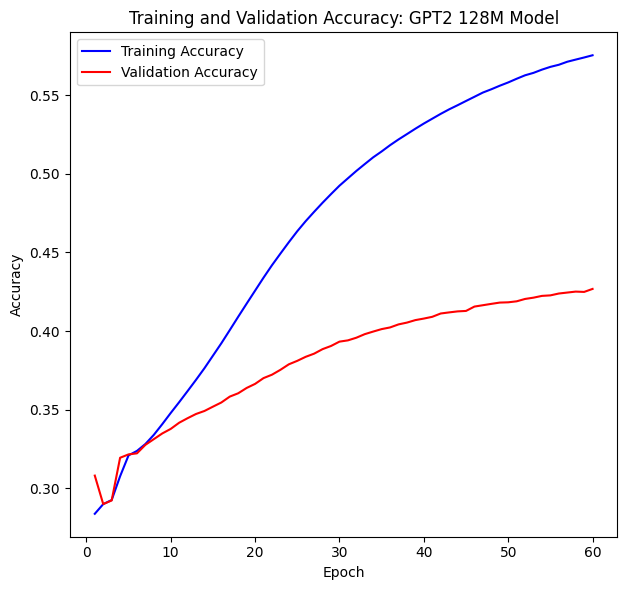

In [10]:
# Path to the log file
file_path = '../src/results/logs/2024-07-19.log'

# Load data from log file
train_loss, val_loss, train_accuracy, val_accuracy = load_data(file_path)

# Plot the metrics
plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy)
